In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

In [4]:
df = pd.DataFrame({'X1':X1, 'X2':X2, 'Y':Y})
df.head()

X1        X2         Y
0  1.843163 -0.184593  2.159038
1  1.076583  0.072035  3.582329
2 -1.212927 -0.221551 -1.337775
3 -1.504435  0.269698  0.838060
4 -0.431658 -0.139645  1.364611

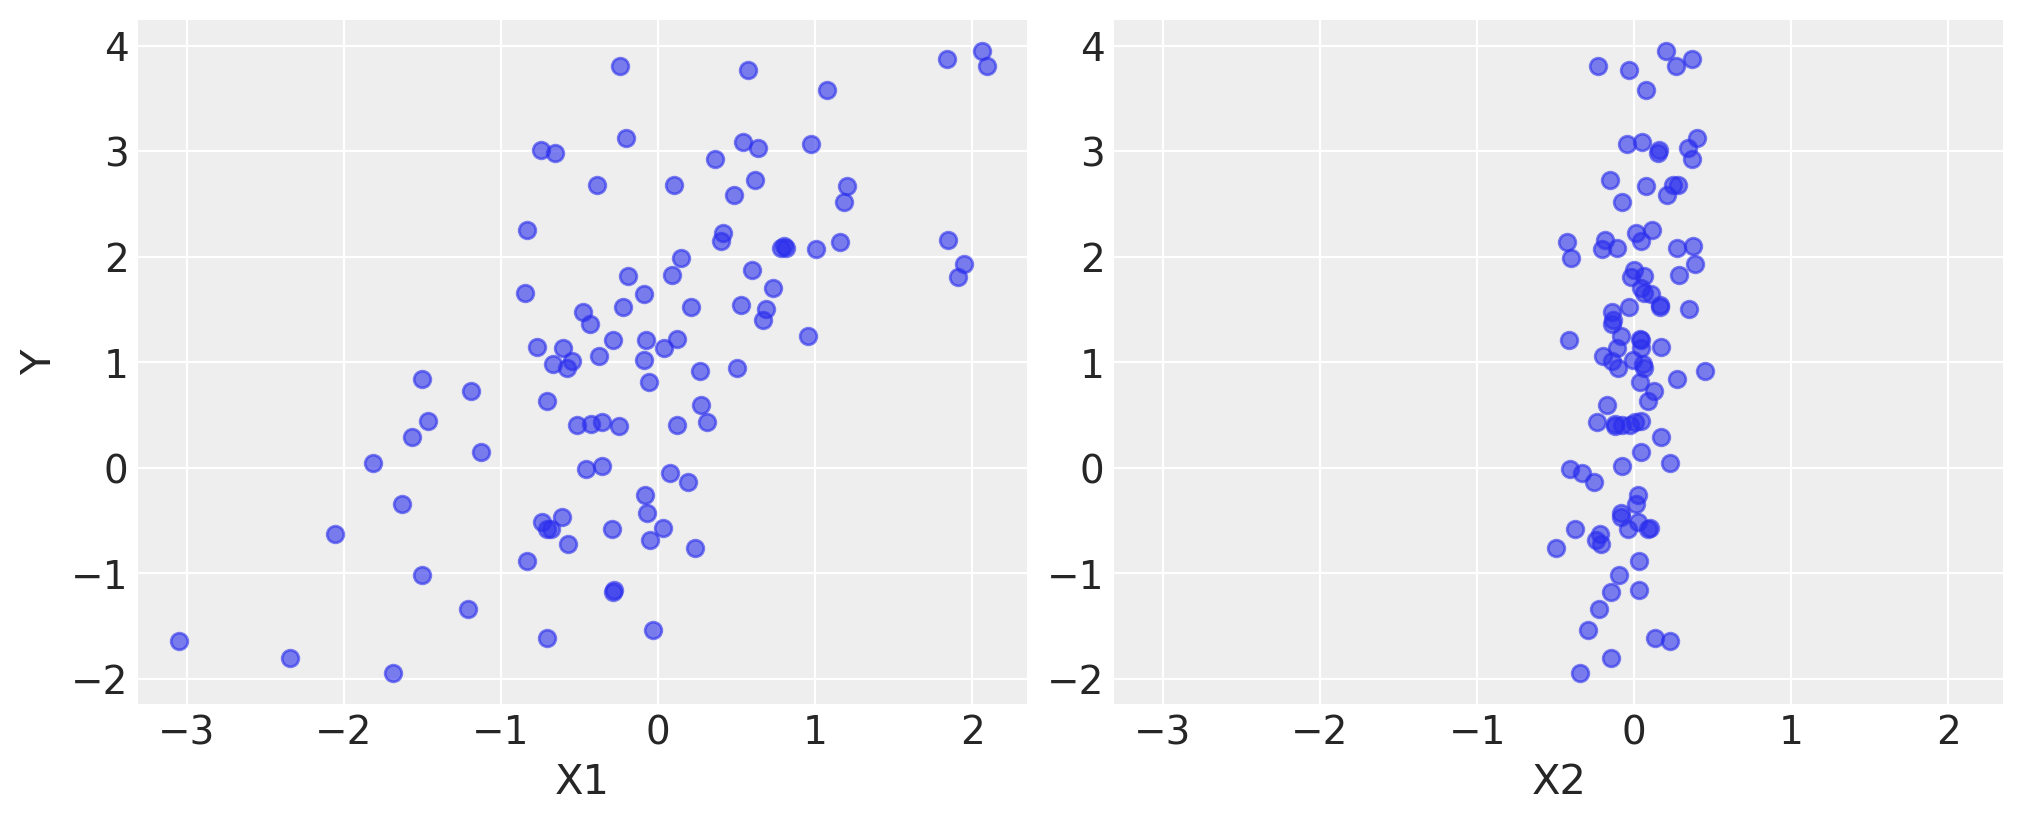

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [6]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.0


In [7]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [8]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [10]:
# We can see the first 5 values for the alpha variable in each chain as follows:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[0.99778058, 1.06119144, 1.27312524, 1.27312524, 1.21138853],
       [1.22125915, 1.13622747, 1.18764686, 1.03250014, 1.27497011],
       [0.95337321, 0.95000993, 1.11471324, 1.17260658, 1.17260658],
       [1.03129795, 1.04254735, 1.30844408, 1.17265924, 1.16765265]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

In [11]:
# Using the slice sampling algo
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


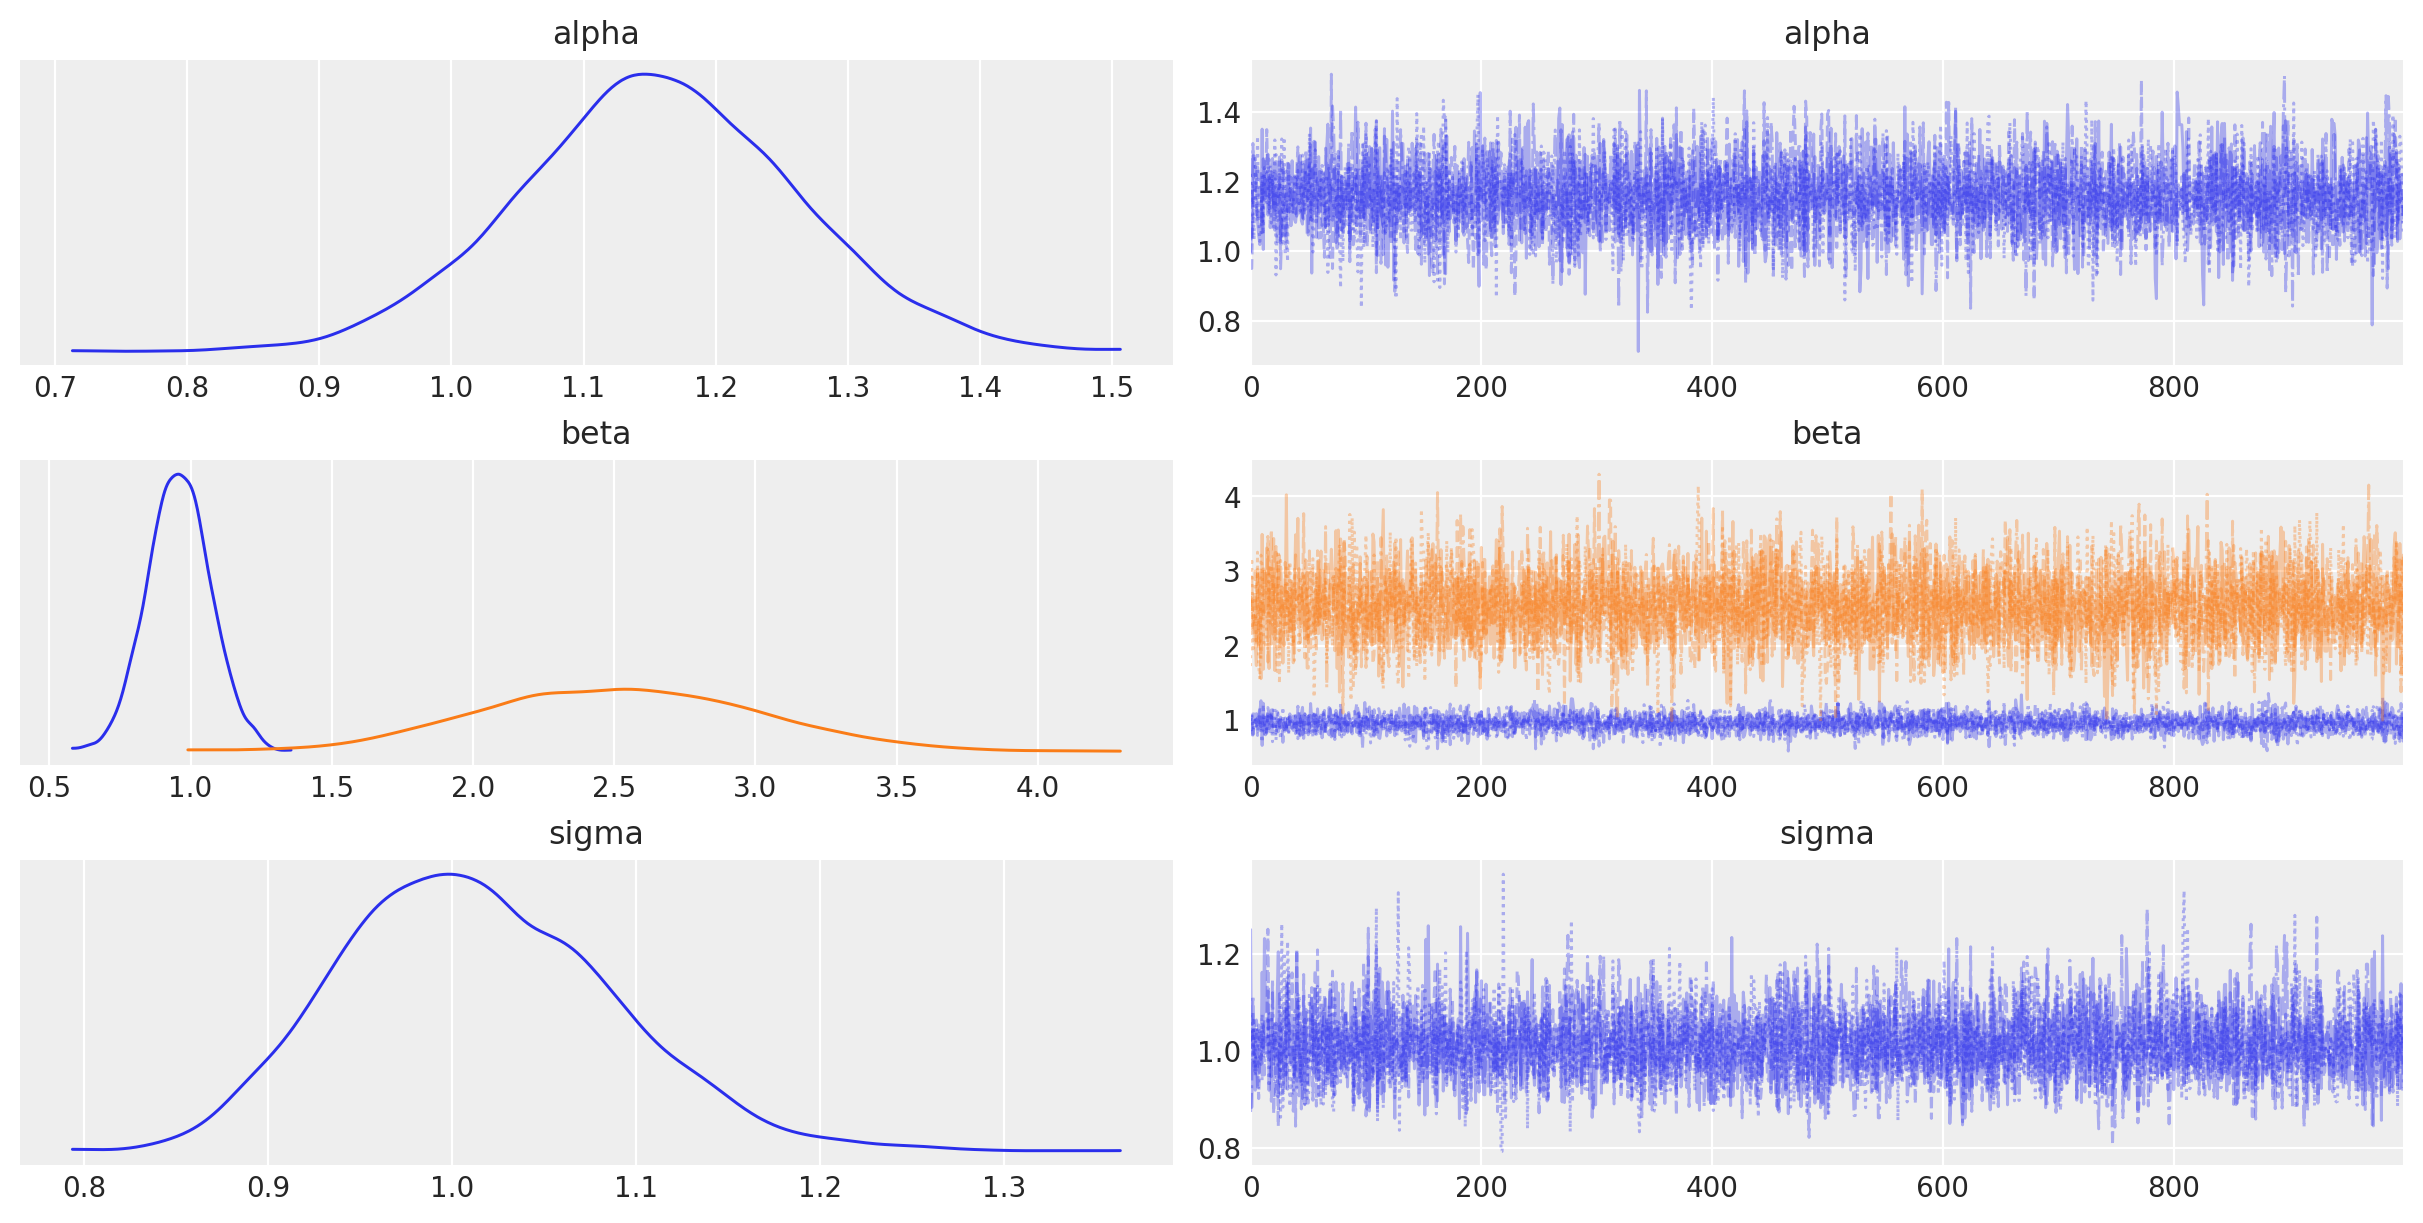

In [12]:
# Posterior analysis
az.plot_trace(idata, combined=True);

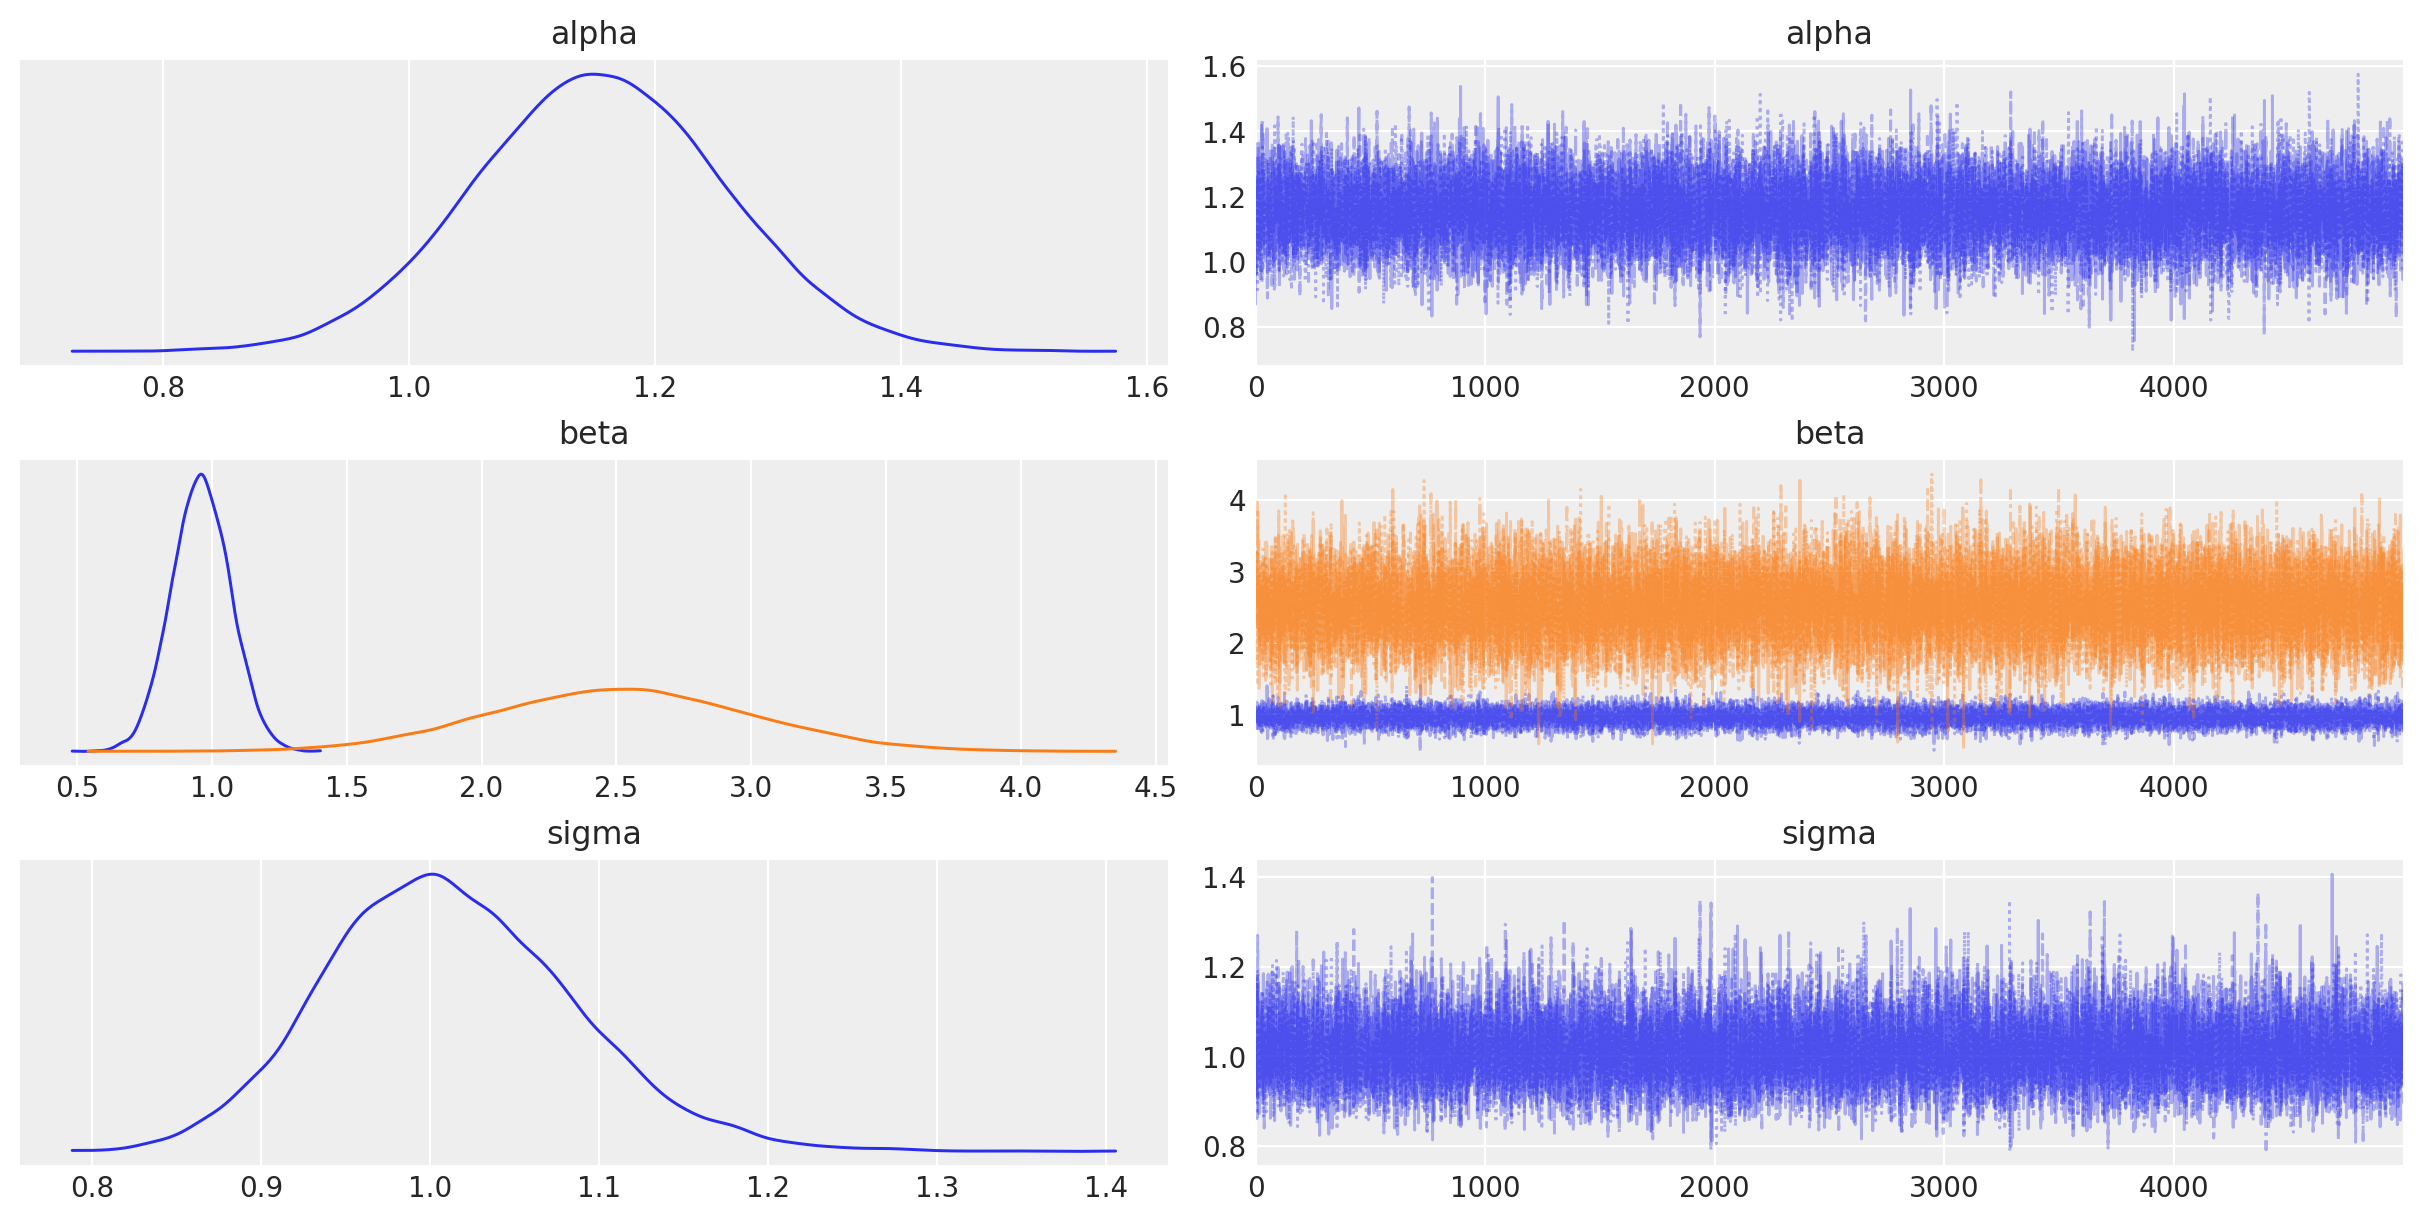

In [13]:
az.plot_trace(slice_idata, combined=True);

In [14]:
az.summary(idata, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    1.16  0.10    0.96     1.35       0.00      0.0   7082.55   3067.02   
beta[0]  0.96  0.11    0.75     1.17       0.00      0.0   5354.50   2677.20   
beta[1]  2.52  0.49    1.62     3.43       0.01      0.0   5633.68   3218.87   
sigma    1.01  0.07    0.88     1.15       0.00      0.0   6588.97   3249.37   

         r_hat  
alpha      1.0  
beta[0]    1.0  
beta[1]    1.0  
sigma      1.0

# Case Study 1 - Educational outcomes for hearing impaired students
Taken from https://www.pymc.io/projects/docs/en/v5.9.0/learn/core_notebooks/pymc_overview.html

In [15]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

score  male  siblings  family_inv  non_english  prev_disab  age_test  \
0     40     0       2.0         2.0        False         NaN        55   
1     31     1       0.0         NaN        False         0.0        53   
2     83     1       1.0         1.0         True         0.0        52   
3     75     0       3.0         NaN        False         0.0        55   
5     62     0       0.0         4.0        False         1.0        50   

   non_severe_hl  mother_hs  early_ident  non_white  
0            1.0        NaN        False      False  
1            0.0        0.0        False      False  
2            1.0        NaN        False       True  
3            0.0        1.0        False      False  
5            0.0        NaN        False      False

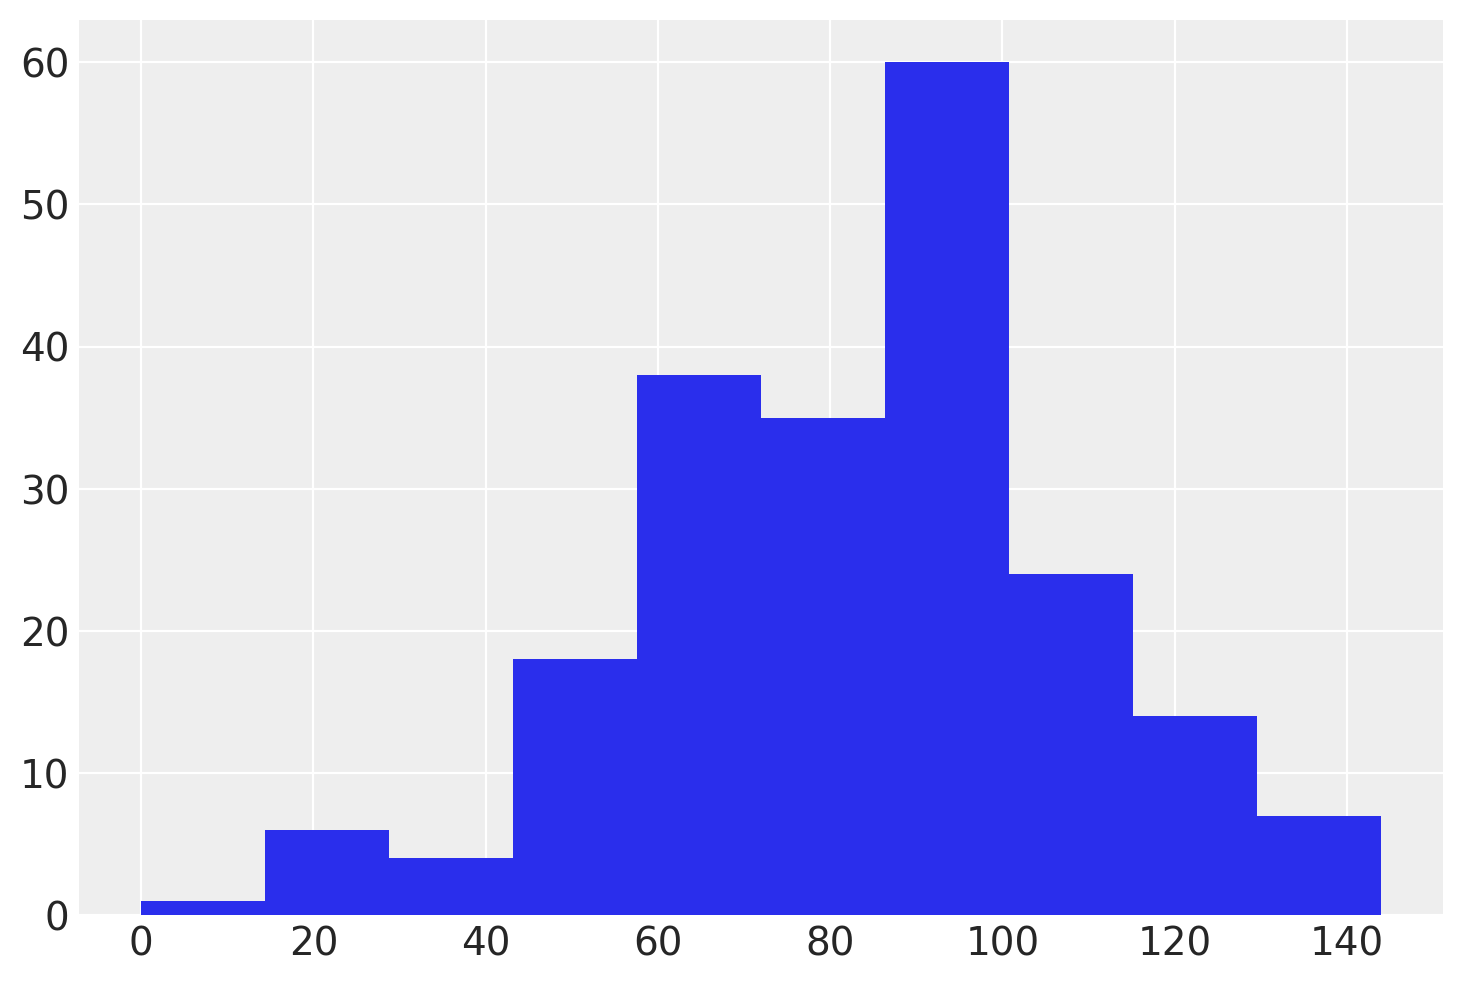

In [16]:
test_scores["score"].hist();

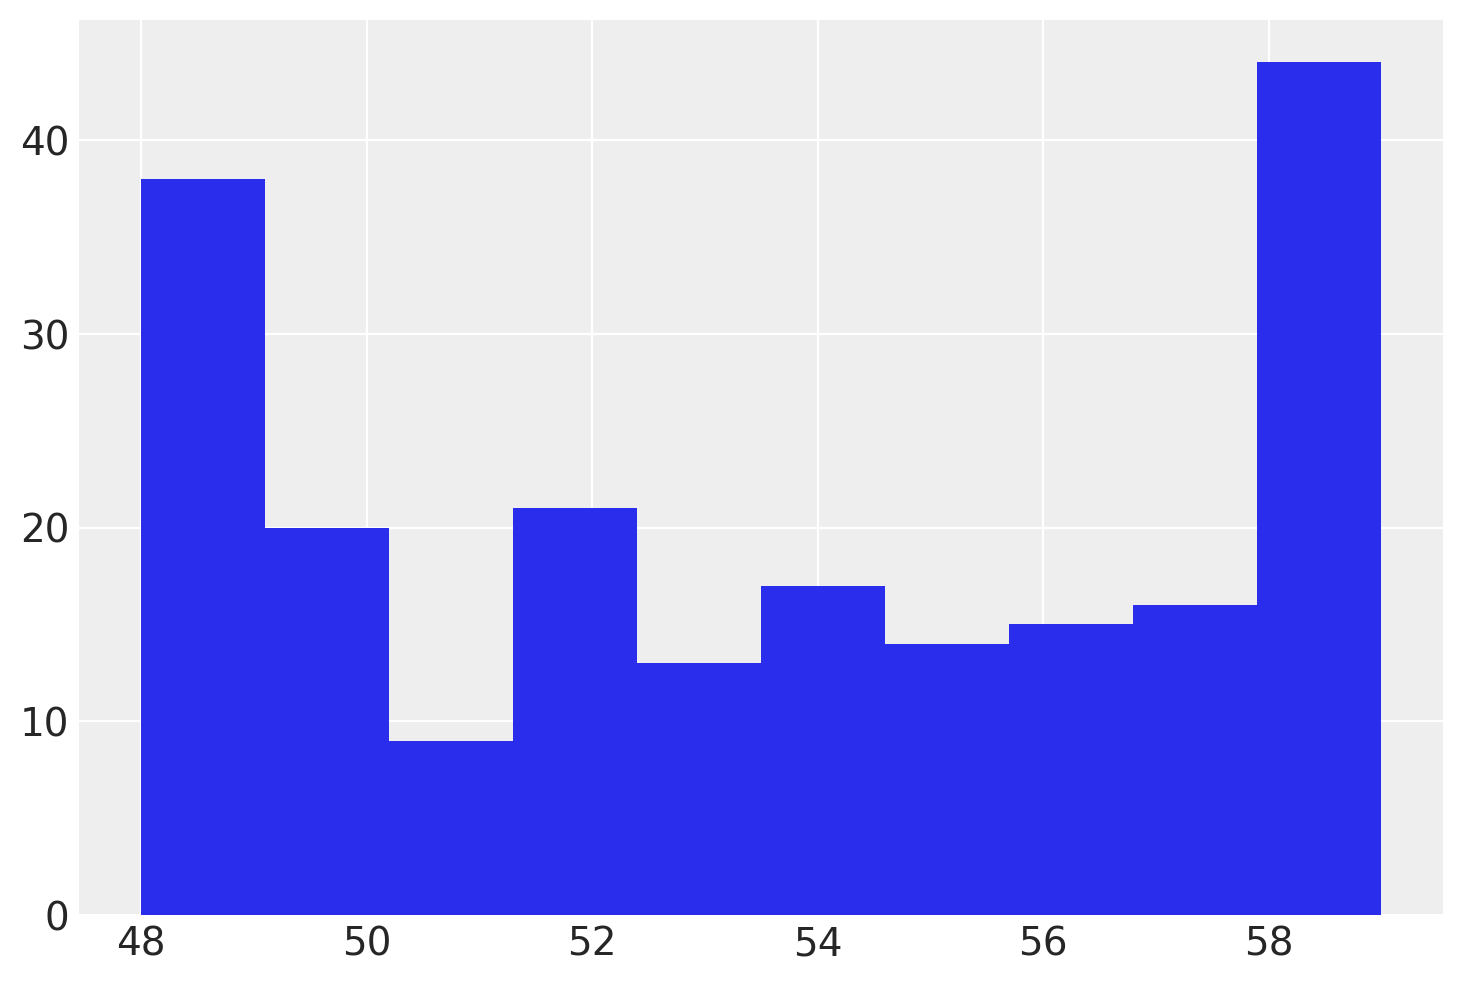

In [17]:
test_scores["age_test"].hist();

In [27]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)

y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [41]:
X.head()

male  siblings  family_inv  non_english  prev_disab  age_test  \
7  -1.004938  1.078165    2.227502     2.480475    1.782293 -0.978004   
12  0.985234 -0.080289   -0.911722    -0.399157   -0.555520 -1.562492   
14 -1.004938  1.078165   -0.911722    -0.399157   -0.555520  1.359947   
19  0.985234 -1.238742    1.181094    -0.399157   -0.555520 -0.978004   
21  0.985234 -0.080289    1.181094    -0.399157    1.782293  1.359947   

    non_severe_hl  mother_hs  early_ident  non_white  
7        1.179344   0.616250    -0.772789   1.132532  
12       1.179344   0.616250     1.281203  -0.874235  
14       1.179344   0.616250     1.281203   1.132532  
19       1.179344   0.616250    -0.772789   1.132532  
21      -0.839533  -1.606652     1.281203   1.132532

## Apply Bayesian regularisation
Ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes

### hierarchical regularized horseshoe
Uses two regularization strategies, one global and a set of local parameters, one for each coefficient.

In [40]:
D0 = int(D / 2)

In [45]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

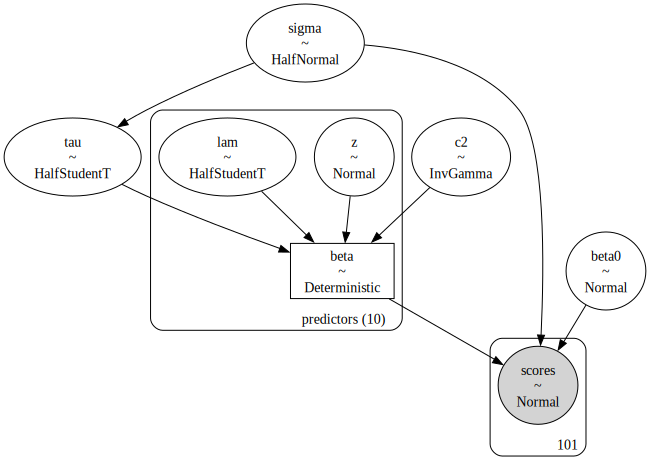

In [46]:
pm.model_to_graphviz(test_score_model)

## Prior Predictive Sampling

In [47]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


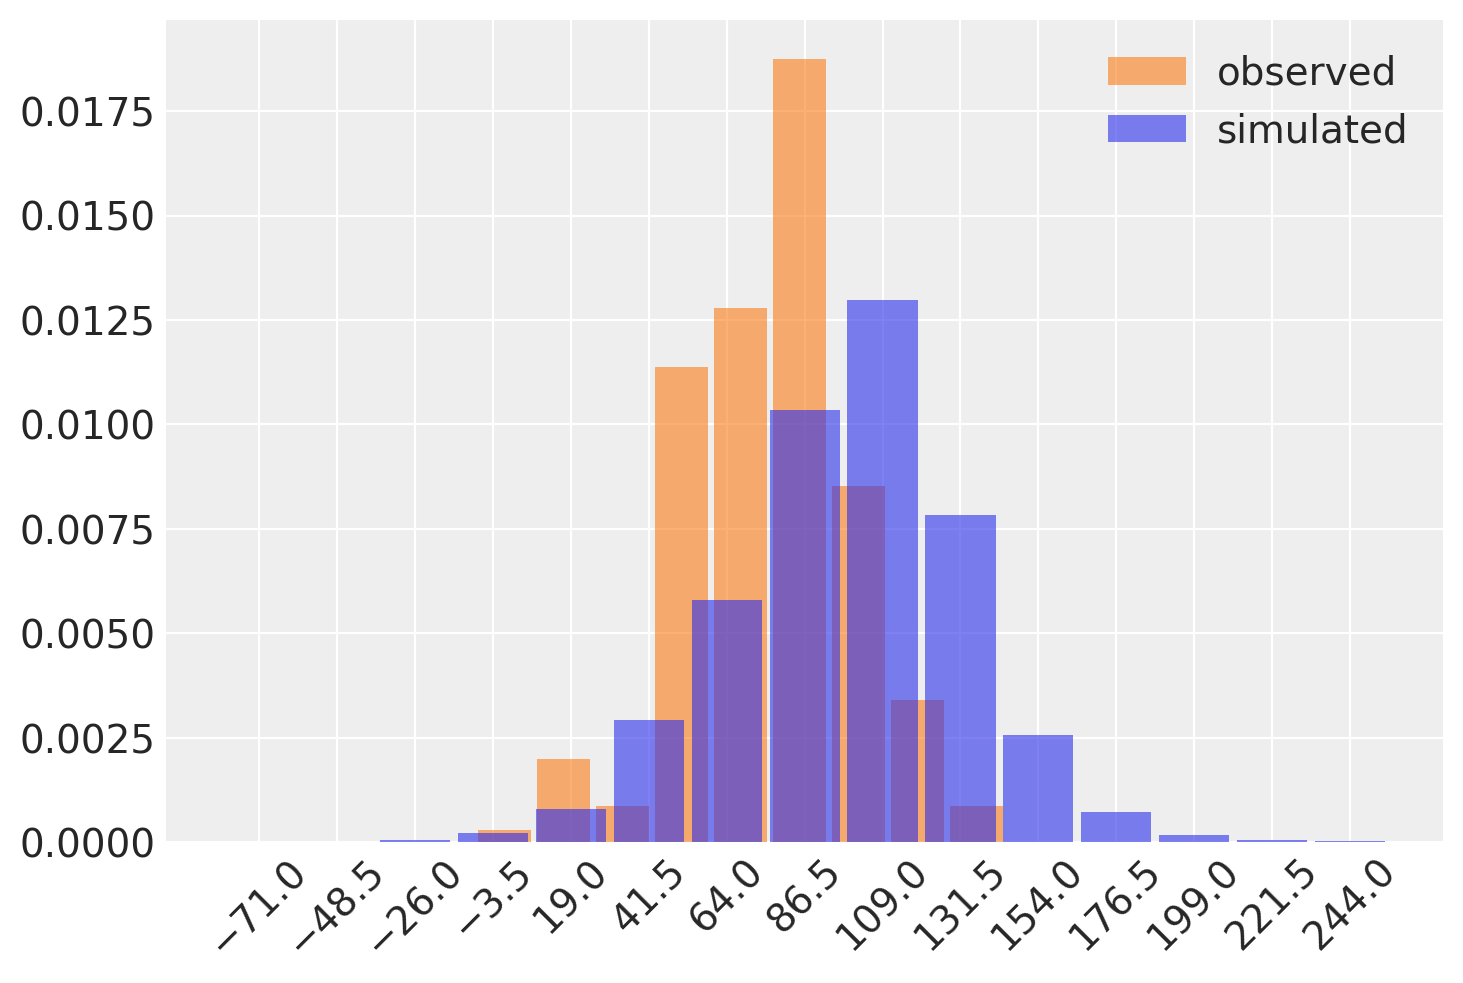

In [48]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

## Model fitting

In [49]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [50]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 63 seconds.


## Model Checking

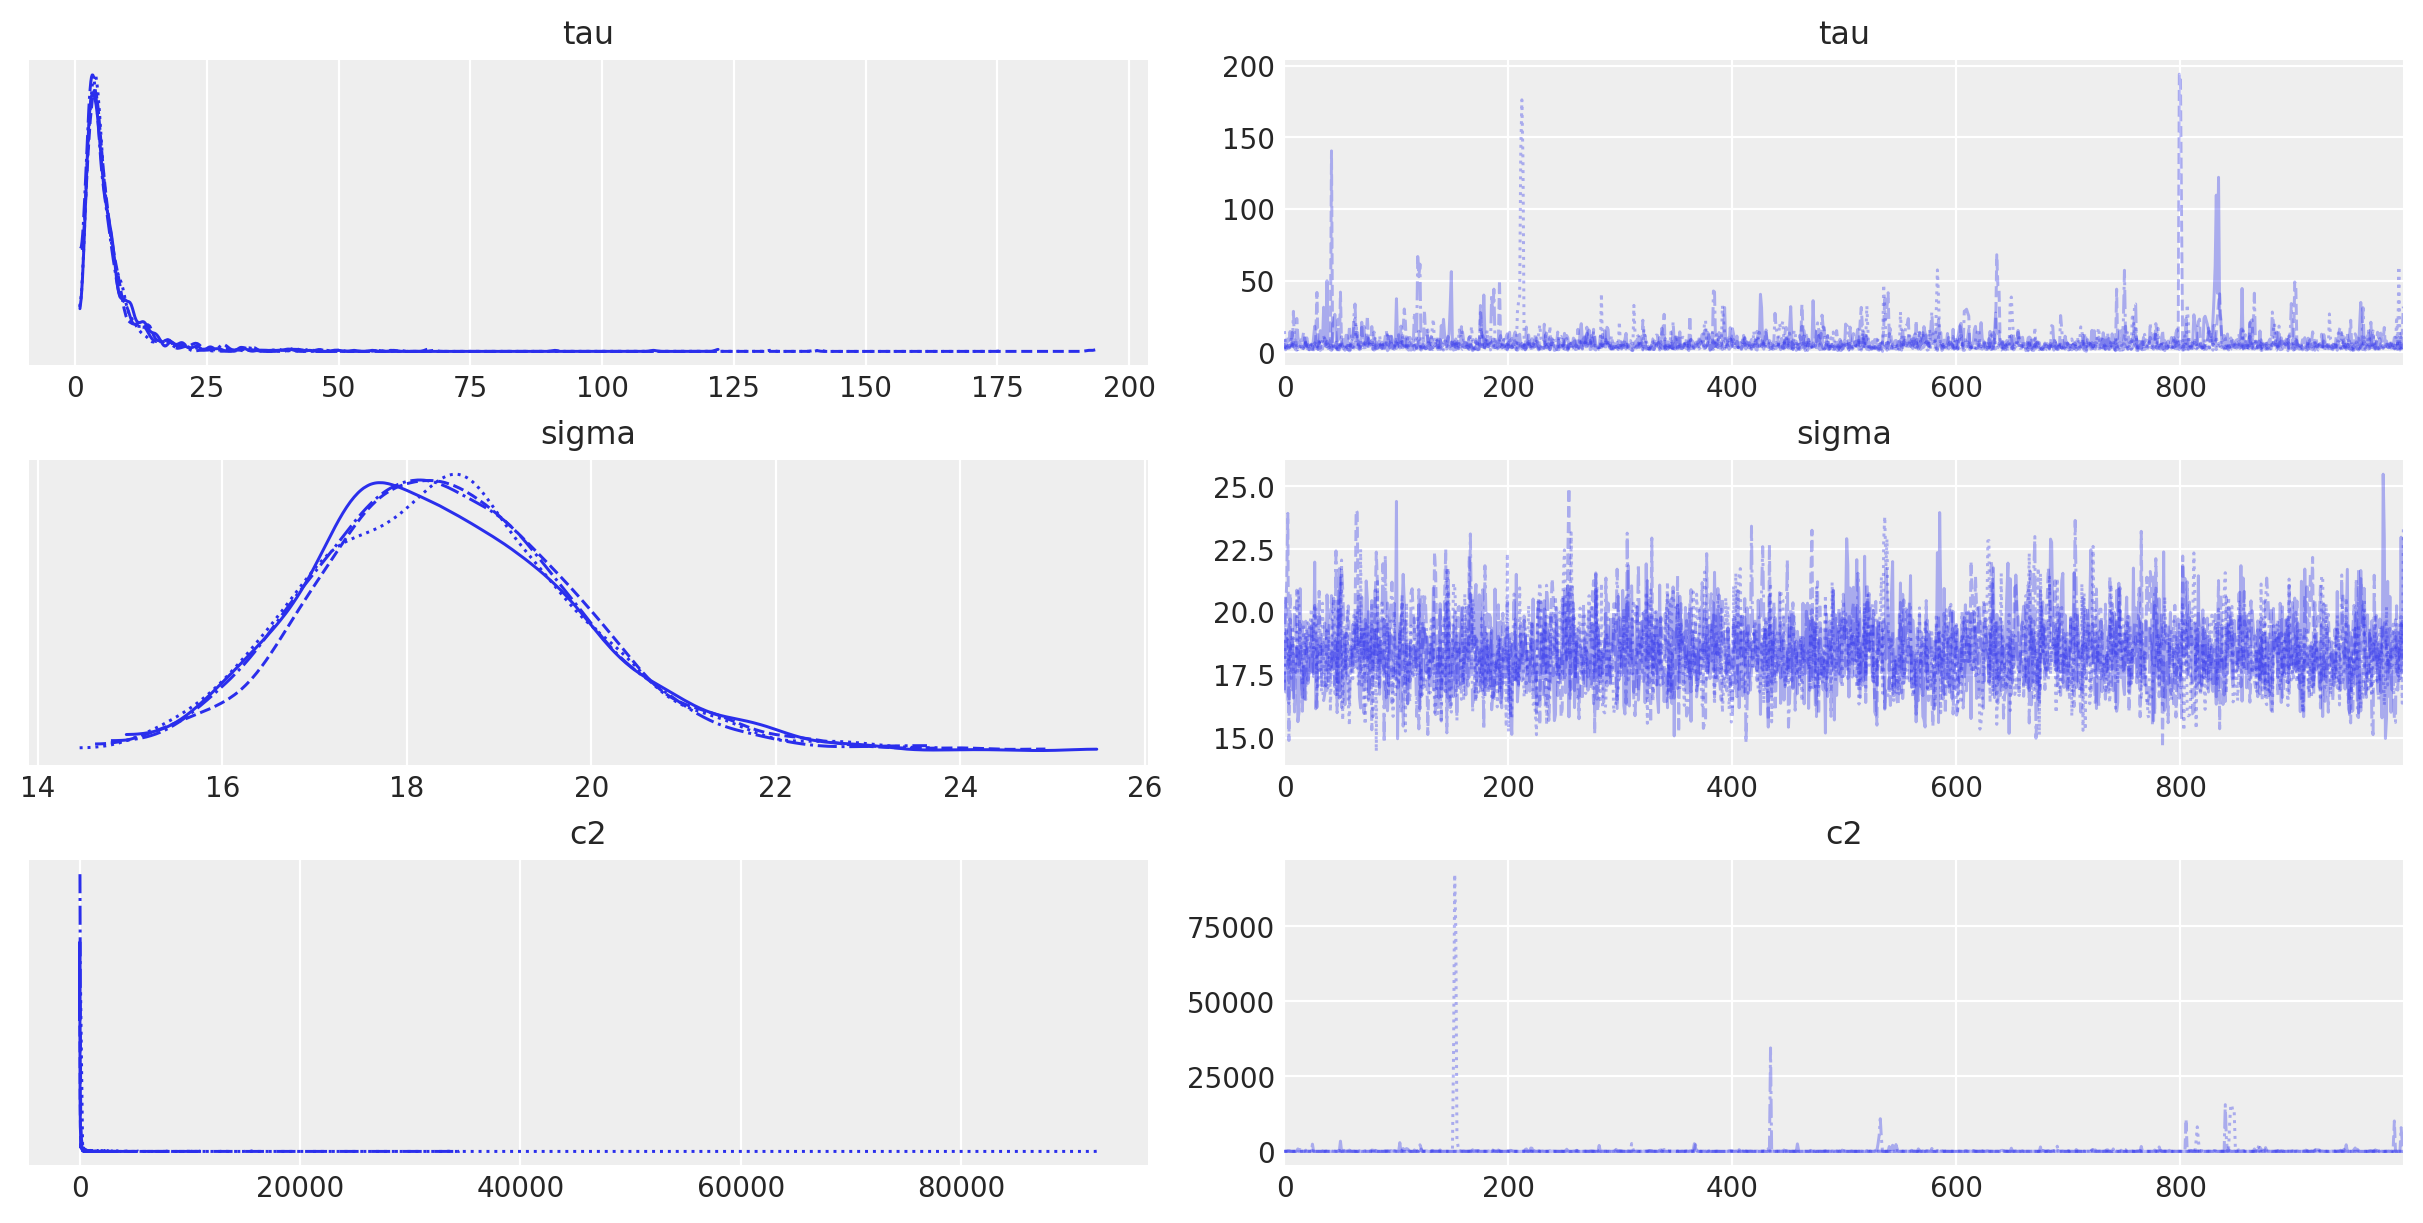

In [51]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

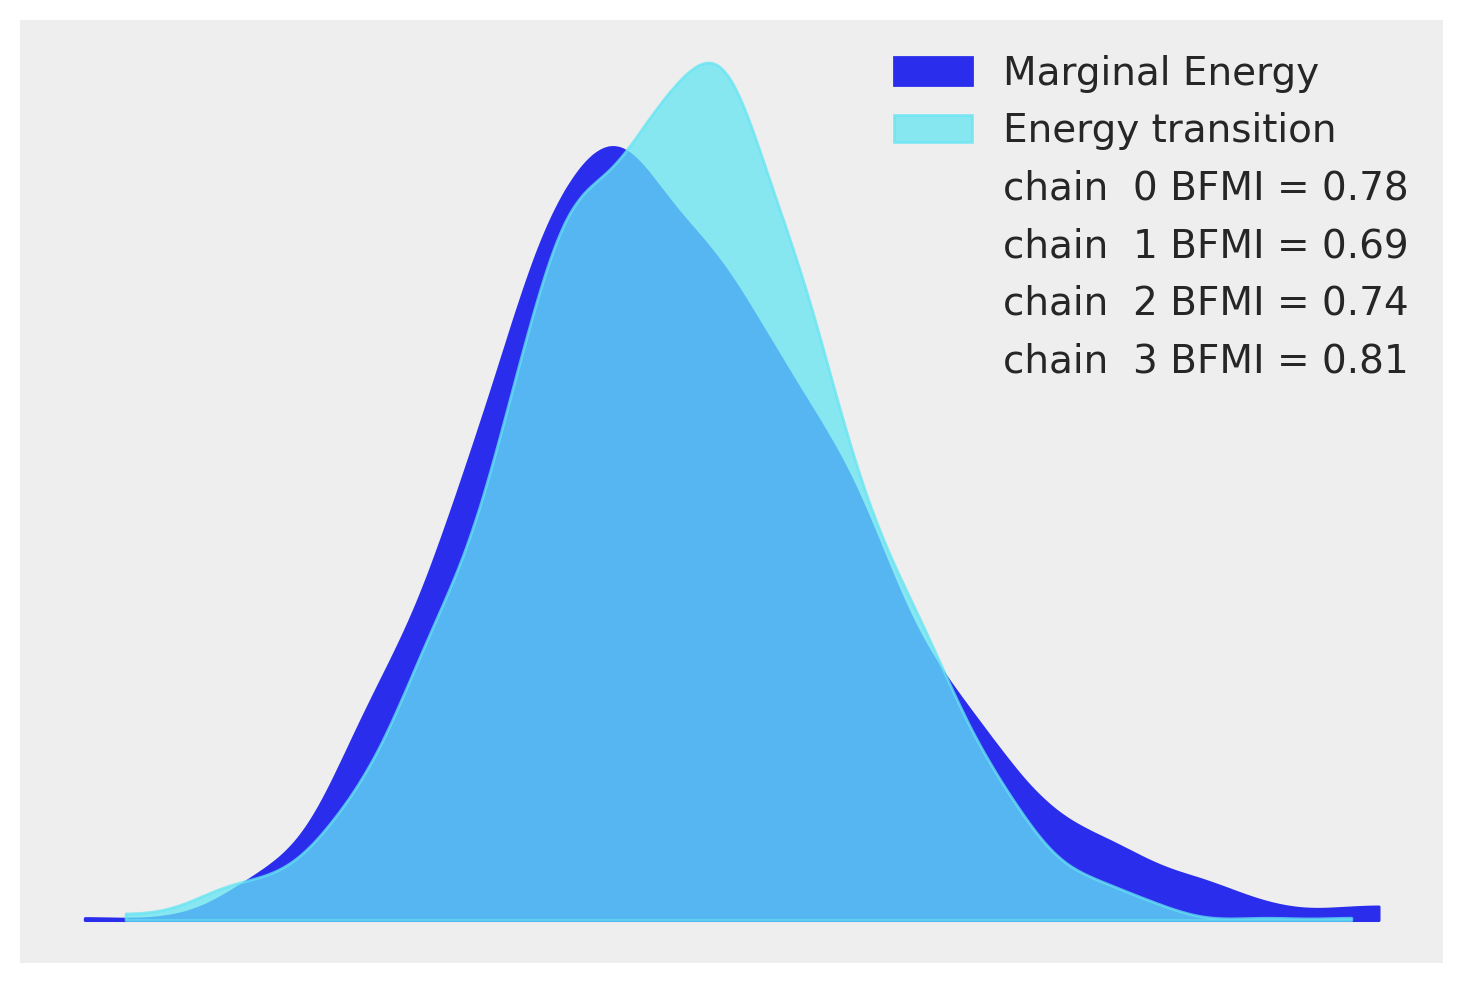

In [53]:
# The energy distribution plots should be similar
az.plot_energy(idata);

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

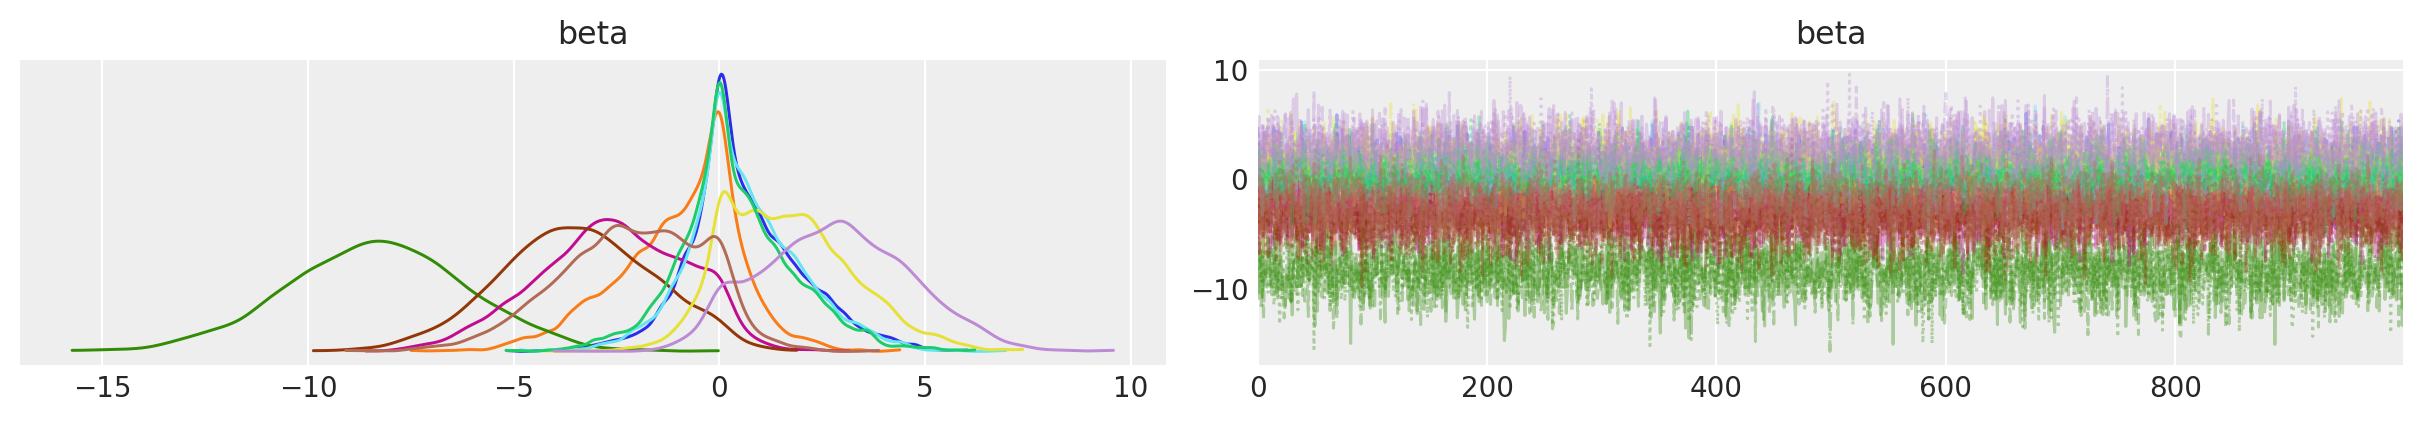

In [56]:
az.plot_trace(idata, var_names=["beta"], combined=True);

In [57]:
# use plot_forest instead of plot_trace which was a bit crowded, which is designed to handle vector-valued parameters.
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

# Case Study 2 - Coal mining disasters
https://www.pymc.io/projects/docs/en/v5.9.0/learn/core_notebooks/pymc_overview.html#case-study-2-coal-mining-disasters

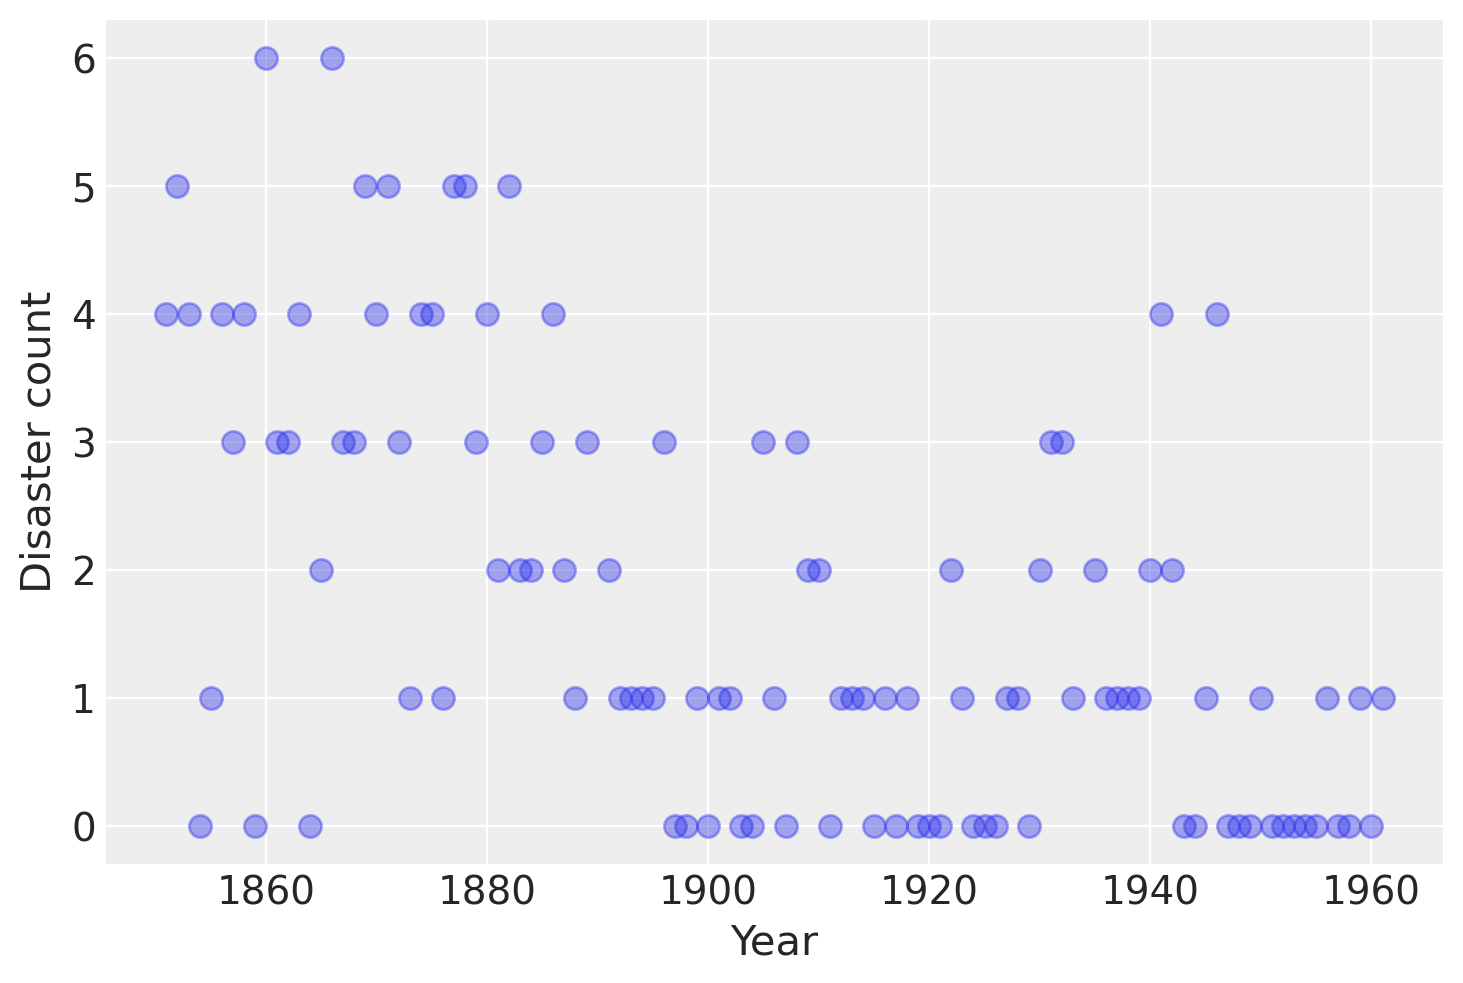

In [58]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [59]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/home/mrosinski/mambaforge/envs/pymc_env/lib/python3.11/site-packages/pymc/model/core.py:1342: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/home/mrosinski/mambaforge/envs/pymc_env/lib/python3.11/site-packages/pymc/model/core.py:1365: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


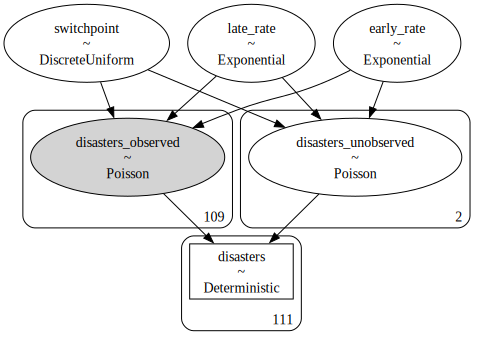

In [62]:
pm.model_to_graphviz(disaster_model)

In [61]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.


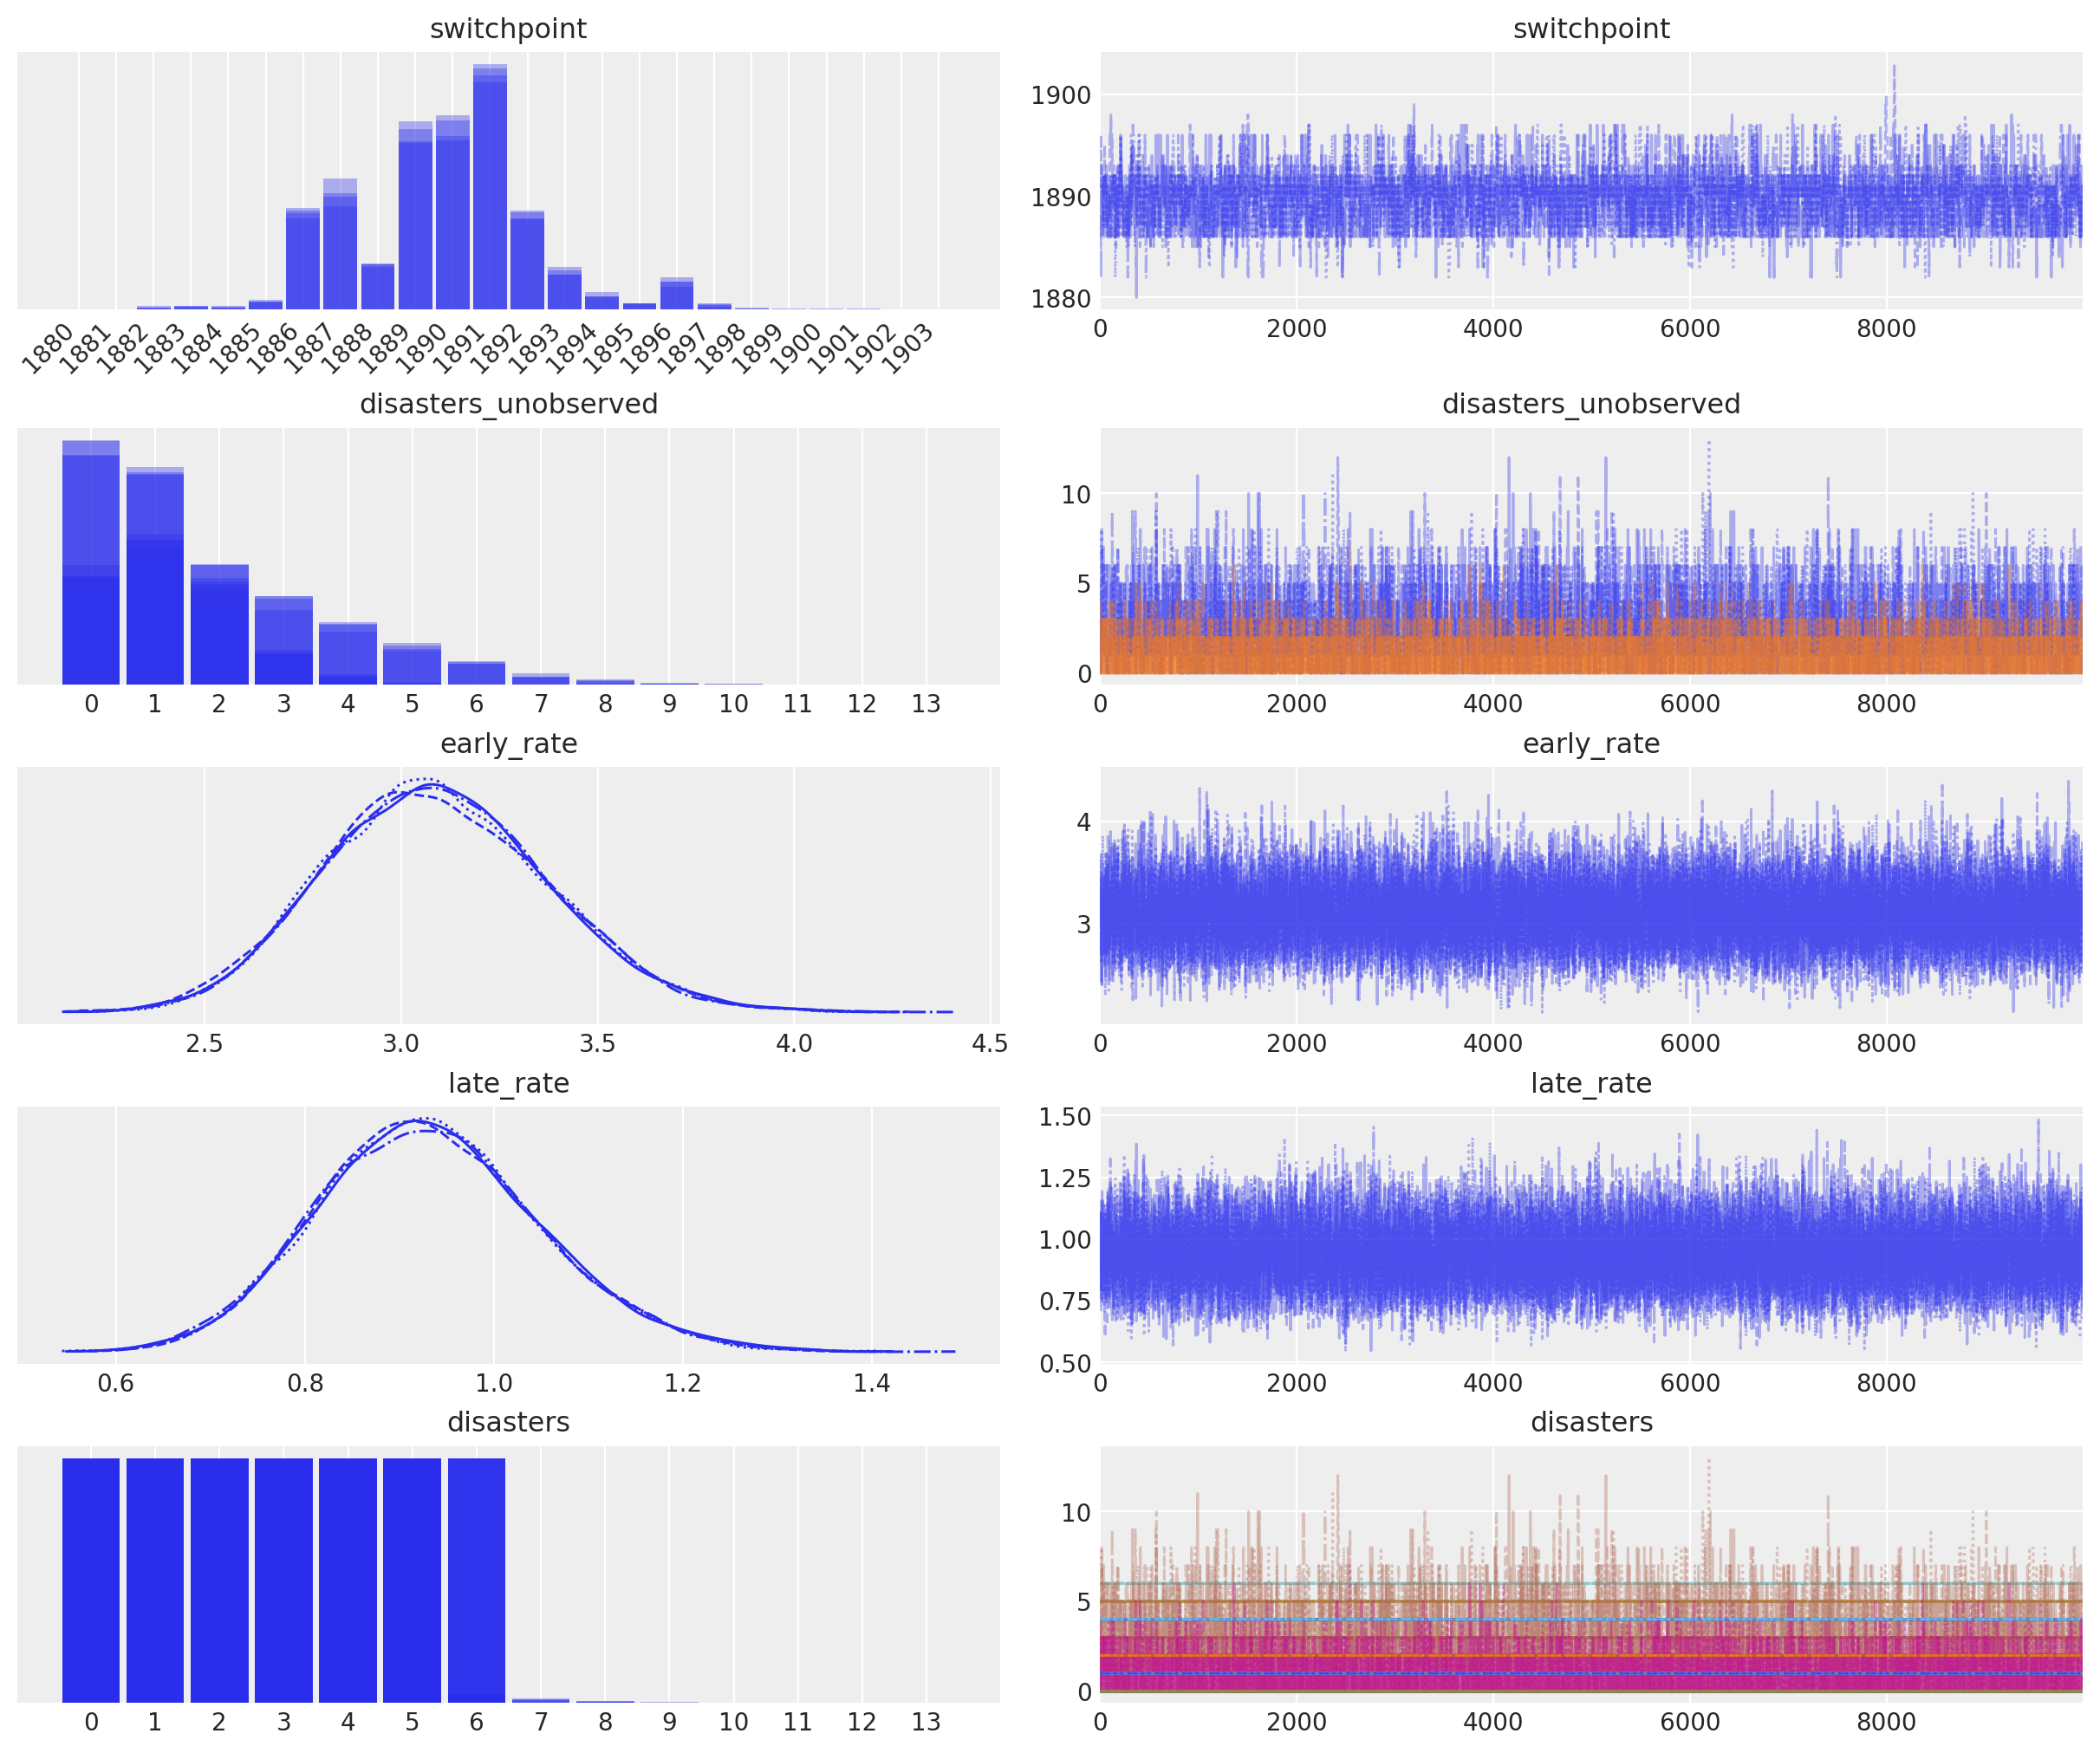

In [63]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

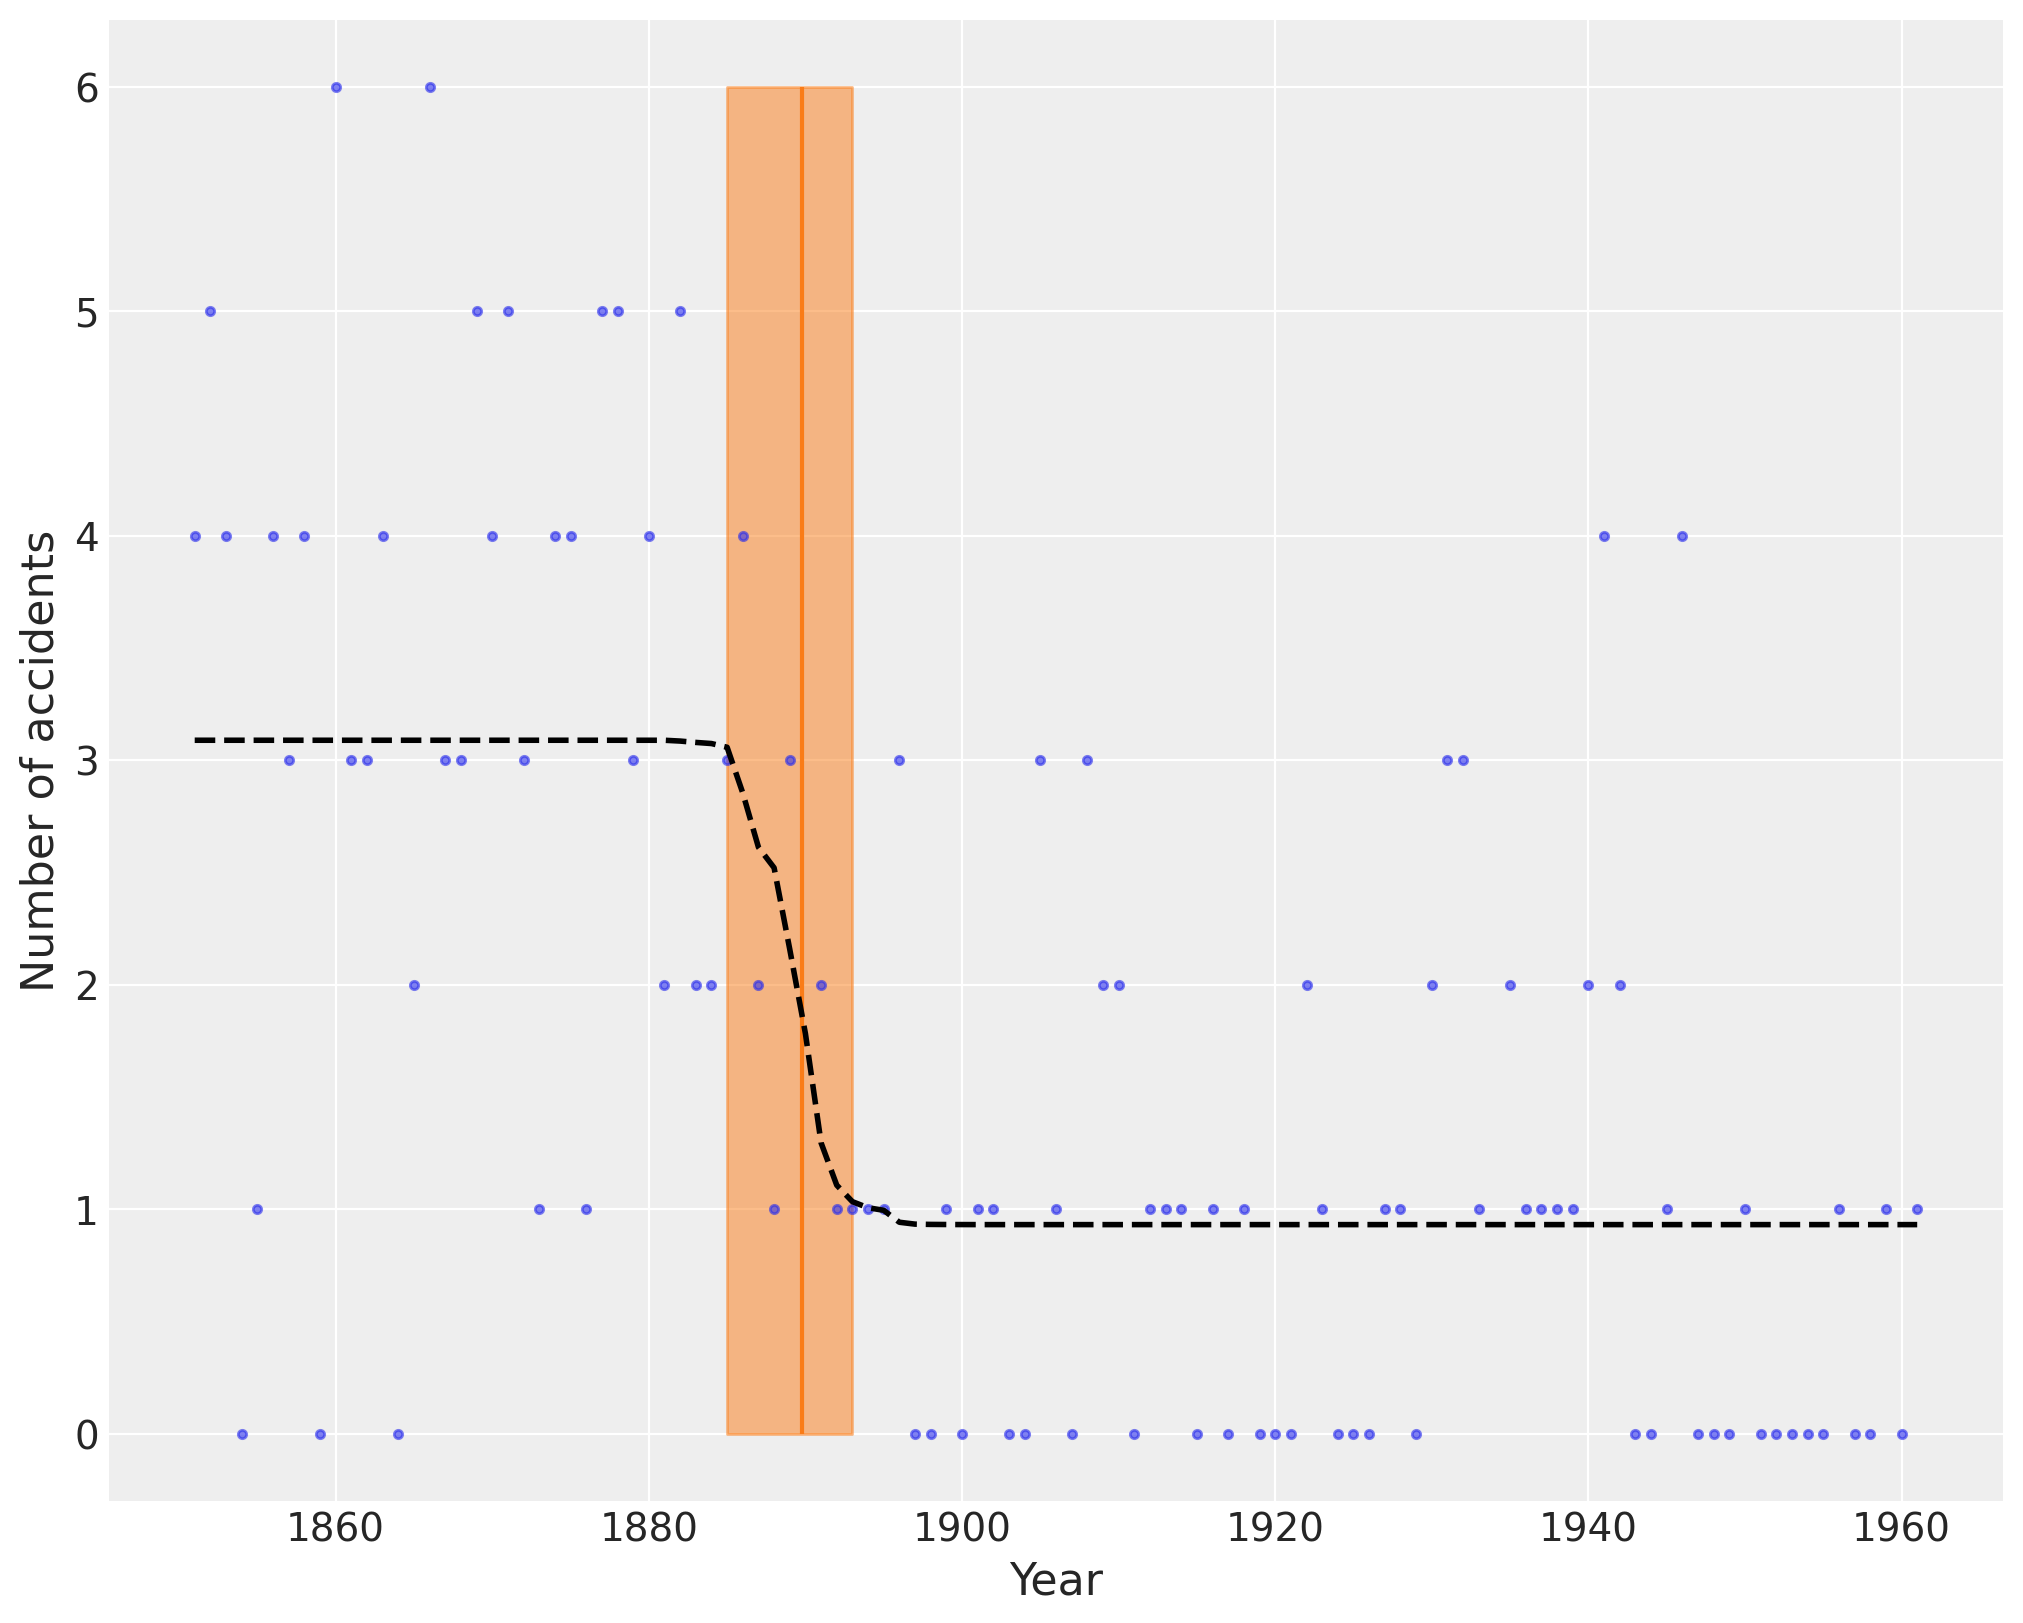

In [64]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

# Creating Arbitrary Deterministics

In [65]:
from pytensor.compile.ops import as_op

@as_op(itypes=[at.lscalar], otypes=[at.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else:
        return (-value + 1) % 3

with pm.Model() as model_deterministic:
    a = pm.Poisson("a", 1)
    b = crazy_modulo3(a)

# Creating Arbitrary Distributions

In [67]:
import pytensor.tensor as at

In [74]:
with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = pm.DensityDist('beta', logp=lambda value: -1.5 * at.log(1.0 + value**2))
    eps = pm.DensityDist('eps', logp=lambda value: -at.log(at.abs_(value)))
    # beta = pm.Normal("beta", 0.0, 1.0)
    # eps = pm.HalfNormal("eps", 25)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)

ValueError: Size length is incompatible with batched dimensions of parameter 0 Add.0:
len(size) = 1, len(batched dims Add.0) = 2. Size length must be 0 or >= 2